In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import pickle
import matplotlib.pyplot as plt
import string
import math
from tqdm import tqdm  # For nice progress bar!

In [3]:
# Mount drive to get data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## The Convolutional Neural Network

In [55]:
# Must understand Conv2d to be able to debug/understand this. Will watch lectures soon

class CNN(nn.Module):

    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 8, (3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(8, 16, (3, 3), stride=(1, 1), padding=(1, 1))
        self.fc1 = nn.Linear(16*7*7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        #x = x.view(x.size[0], -1)
        x = self.fc1(x)
        return x

In [76]:
# Model number 2. This is simple feedforward, used to just make sure things work.

class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [57]:
# Implement CONV Net - other conv net
# Must understand Conv2d to be able to debug/understand this. Will watch lectures soon

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = torchvision.models.resnet34(pretrained=False)
        self.conv1 = nn.Conv2d(1, 6, 5) # input channel (rgb), output channel, kernel size 
        self.pool = nn.MaxPool2d(2, 2) # define 2x2 stride for max-pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # input channel size = output channel size of previous conv layer
        self.fc1 = nn.Linear(16*11*11, 120) # fully connected layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))  
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # activation function does not change size
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*11*11) # -1 tells PyTorch to infer num batches # flatten tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # no activation at end, softmax included in CrossEntropyLoss
        return x





In [79]:
# Basic Check To see if net makes sense. Something is wrong with my CNN.
# DOn't really understand it yet, but this code below should used to just check if
# the inputs and outputs work.


dummy_model = NN(3136, 36)
random_input = torch.randn(64, 3136)
print(dummy_model(random_input).shape)


torch.Size([64, 36])


## Hyper-parameters

In [63]:
# Hyper-parameters
input_channels = 3136
num_classes = 36

BATCH_SIZE = 100
LEARNING_RATE = 0.001
NUM_EPOCHS = 4

## Load and Show Data

In [66]:
alpha_dict = dict(enumerate(string.ascii_lowercase))
print(alpha_dict)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [67]:
def get_label_value(labels):
  """
  This function will return a string representing the label of a picture given
  the array label as input:
  Ex ouput: '1a', '4z' ...
  """
  label_temp = labels.tolist()
  label_temp = [int(x) for x in label_temp]
  number = label_temp[:10].index(1)
  letter = alpha_dict[label_temp[10:].index(1)]

  return str(number) + str(letter)
  


In [68]:
def load_data(filepath):
    loaded_pkl = None
    try:
        with open(filepath, 'rb') as pkl_buffered:
            loaded_pkl = pickle.load(pkl_buffered)
        return loaded_pkl
    except Exception as e:
        print("Error loading data: {}".format(e))
    

In [69]:
train_test_percentage = .3

train_data = load_data("/content/drive/MyDrive/McGill/COMP551/data/images_l.pkl")
train_labels = load_data("/content/drive/MyDrive/McGill/COMP551/data/labels_l.pkl")

# Split train into train and test
old_length_train = len(train_data)
old_length_test = len(train_data)

test_data = train_data[:math.floor(old_length_train*.3)]
train_data = train_data[math.floor(old_length_train*.3):]

test_labels = train_labels[:math.floor(old_length_test*.3)]
train_labels = train_labels[math.floor(old_length_test*.3):]


In [70]:
print(train_data.shape)
print(test_data.shape)

(21000, 56, 56)
(9000, 56, 56)


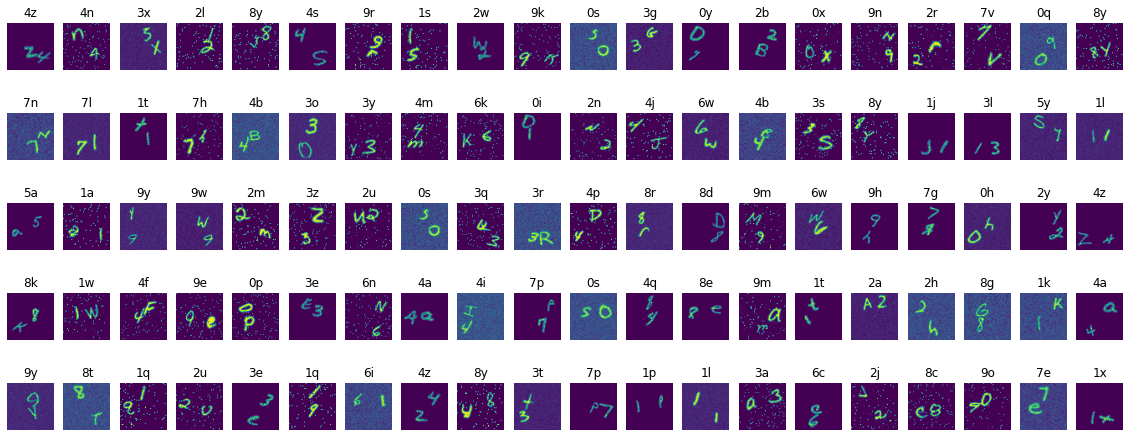

In [71]:
# Visualize some data

figure = plt.figure(figsize=(20, 8))
cols, rows = 20, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img = train_data[sample_idx]
    label = get_label_value(train_labels[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

In [83]:
# Turn data and labels into a DataLoader
train_loader = DataLoader(TensorDataset(torch.Tensor(train_data),
                                    torch.Tensor(train_labels)), shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(torch.Tensor(test_data),
                                    torch.Tensor(test_labels)), shuffle=True, batch_size=BATCH_SIZE)



## Define All Classes

In [73]:
# Define classes
classes = []
for l in range(26):
    letter_str = [0.0 for i in range(26)]
    letter_str[l] = 1.0
    for d in range(10):
        digits_str = [0.0 for j in range(10)]
        digits_str[d] = 1.0
        c = digits_str + letter_str
        # c = "".join(c_str)
        classes.append(c)
print(len(classes))

260


## Initialize

In [86]:
model = NN(input_size=input_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train

In [94]:
# Train Network
for epoch in range(NUM_EPOCHS):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape
        data = data.reshape(data.shape[0], -1)

        # forward
        scores = model(data)
        print(scores)
        print(targets)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

  0%|          | 0/210 [00:00<?, ?it/s]

tensor([[ 19.6979, -20.6366,  -4.7425,  ..., -17.2398,  17.9256,  19.0439],
        [ 15.1706,  -0.4256,  -1.1769,  ..., -13.9779,  10.6498,   2.9192],
        [  7.2277,   0.6471,   4.9217,  ...,   4.2769,  12.6868,   1.6886],
        ...,
        [ 36.7680, -32.1499,   1.5103,  ..., -24.5514,  18.3532,  33.1968],
        [ 11.6027, -15.0737,  -1.5291,  ...,  -9.8510,   1.9394,  19.8270],
        [ 24.8754, -11.8370,   7.3785,  ..., -30.0201,  -0.5627,  23.7178]],
       grad_fn=<AddmmBackward>)
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


RuntimeError: ignored

## Test

In [88]:

def transform_output(scores):
    """
    Input a Tensor and output will be another Tensor with same dimension but with all elements 0 except two.
    Those 2 elements will have value of 1 and will correspond to the models prediction about which letter and number
    is in the image.
    :param scores:
    :return:
    """
    return_array = []
    score_list = scores.tolist()

    for score in score_list:
        numbers = score[:10]
        letters = score[10:]
        test = lambda x, max_value : 1 if x >= max_value else 0

        new_numbers = [test(x, max(numbers)) for x in numbers]
        new_letters = [test(x, max(letters)) for x in letters]

        return_array.append(new_numbers + new_letters)

    return torch.Tensor(return_array)

In [89]:
# Check accuracy on training & test to see how good our model
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)

            predictions = transform_output(scores)

            temp = (predictions == y)
            results = [all(el) for el in temp]

            num_correct += sum(results)
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [91]:
# This actually runs the tests on train and test set.

print(f"Accuracy on training set: {get_accuracy(train_loader, model) * 100:.2f}%")
print(f"Accuracy on test set: {get_accuracy(test_loader, model) * 100:.2f}%")

Accuracy on training set: 0.41%
Accuracy on test set: 0.39%


## Save Predictions to CSV

In [ ]:
# Will most likely incorporate this into get_accuracy function.
# TODO: make get_acuracy function return an array where the first element is acuracyt and second is the predictions.